# Implementing the knn algorithm

In [2]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from copy import deepcopy

#Carregando o dataset
hcc = pd.read_csv("hcc_dataset.csv", sep=",")

#Ajetiando os valores nulos
hcc.replace(np.nan, 'None', inplace=True) #Na tabela tem células com o valor None que ele interpreta como um np.nan, então precisamos garantir que ele vai entender isso como um valor válido
hcc.replace('?', np.nan, inplace=True) #As células vazias possuem uma '?', então aqui dizemos que essas células sõa NaN

for column in hcc.columns:
    #Convertendo os valores que são numéricos para float
    if hcc[column].dtype == 'object':
        try:
            if hcc[column].apply(lambda x: pd.to_numeric(x, errors='coerce')).notnull().any() and column != 'Nodules':
                hcc[column] = pd.to_numeric(hcc[column], errors='coerce')
        except ValueError:
            try:
                hcc[column] = pd.to_datetime(hcc[column], errors='coerce')
            except ValueError:
                pass

    #Tratando os valores de texto -  colocando para UPPERCASE e colocando algum valor nas células vazias
    if(hcc[column].dtype == 'object'):
        hcc[column] = hcc[column].str.upper()
        value = hcc[column].value_counts().idxmax() # para variáveis categóricas colocamos o valor mais frequente
    else:
        value = hcc[column].mean() # para valores numéricos colocamos a média
    hcc[column].replace(np.nan, value, inplace=True)
    
# Normalize numeric values
scaler = MinMaxScaler()
numeric_columns = hcc.select_dtypes(include=['float64', 'int64']).columns
hcc[numeric_columns] = scaler.fit_transform(hcc[numeric_columns])

# Display the first few rows to verify normalization
hcc.head()

,Gender,Symptoms,Alcohol,HBsAg,HBeAg,HBcAb,HCVAb,Cirrhosis,Endemic,Smoking,...,ALP,TP,Creatinine,Nodules,Major_Dim,Dir_Bil,Iron,Sat,Ferritin,Class
0,MALE,NO,YES,NO,NO,NO,NO,YES,NO,YES,...,0.151954,0.032620,0.067568,1,0.097561,0.013699,0.382138,0.293880,0.196860,LIVES
1,FEMALE,YES,NO,NO,NO,NO,YES,YES,NO,YES,...,0.215518,0.051591,0.125282,1,0.014634,0.062671,0.382138,0.293880,0.196860,LIVES
2,MALE,NO,YES,YES,NO,YES,NO,YES,NO,YES,...,0.110062,0.031600,0.256757,5,0.560976,0.000000,0.125000,0.047619,0.007175,LIVES
3,MALE,YES,YES,NO,NO,NO,NO,YES,NO,YES,...,0.176475,0.042813,0.122973,2,0.692683,0.003425,0.382138,0.293880,0.196860,DIES
4,MALE,YES,YES,YES,NO,YES,NO,YES,NO,YES,...,0.110062,0.030581,0.216216,1,0.365854,0.062671,0.263393,0.119048,0.009865,LIVES


In [3]:
# Criando uma cópia do dataset original para encoding
encoded_hcc = deepcopy(hcc)

# Definindo as colunas com classificação ordinal
columns_classification = {
    'PS': ['ACTIVE', 'RESTRICTED', 'AMBULATORY', 'SELFCARE', 'DISABLED'],
    'Encephalopathy': ['NONE', 'GRADE I/II', 'GRADE III/IV'],
    'Ascites': ['NONE', 'MILD', 'MODERATE/SEVERE']
}

# Transformando as variáveis categóricas em números
for column in encoded_hcc.columns:
    if encoded_hcc[column].dtype == 'object' and column != 'Nodules':  # Verifica se é categórica e não 'Nodules'
        if column in columns_classification:
            # Ensure correct usage of OrdinalEncoder
            categories = [columns_classification[column] + ['UNKNOWN']]  # Adding 'UNKNOWN' to handle unexpected categories
            encoded_hcc[column] = encoded_hcc[column].apply(lambda x: x if x in columns_classification[column] else 'UNKNOWN')
            enc = OrdinalEncoder(categories=categories)
            enc_transform = pd.DataFrame(enc.fit_transform(encoded_hcc[[column]]), columns=[column])
        else:
            enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
            enc_transform = enc.fit_transform(encoded_hcc[[column]])
            enc_transform = pd.DataFrame(enc_transform, columns=enc.get_feature_names_out([column]))
        
        # Tratamento especial para colunas específicas
        if not(column in columns_classification or column == 'Gender' or column == 'Class'):
            enc_transform = enc_transform.filter(regex='_YES$')  # Filtrar apenas colunas com '_YES$'
        elif column == 'Gender':
            enc_transform = enc_transform.filter(regex='_MALE$')  # Considerar apenas '_MALE$'
        elif column == 'Class':
            enc_transform = enc_transform.filter(regex='_LIVES$')  # Considerar apenas '_LIVES$'

        encoded_hcc = encoded_hcc.drop(columns=[column])  # Excluir a coluna original
        encoded_hcc = pd.concat([encoded_hcc, enc_transform], axis=1)  # Concatenar a transformação ao dataset

# Salvar o DataFrame transformado em um novo arquivo CSV
encoded_hcc.to_csv('encoded_hcc.csv', index=False)  # Salvar o DataFrame codificado em um arquivo CSV

In [4]:
encoded_hcc

,Age,Grams_day,Packs_year,INR,AFP,Hemoglobin,MCV,Leucocytes,Platelets,Albumin,...,Varices_YES,Spleno_YES,PHT_YES,PVT_YES,Metastasis_YES,Hallmark_YES,PS,Encephalopathy,Ascites,Class_LIVES
0,0.643836,0.274000,0.029412,0.173367,0.000052,0.635036,0.740519,0.000208,0.000212,0.500000,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,3.0,1.0
1,0.575342,0.000000,0.040126,0.146194,0.010660,0.575110,0.511372,0.113232,0.246634,0.515178,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,3.0,1.0
2,0.794521,0.100000,0.098039,0.030151,0.000003,0.284672,0.205589,0.000477,0.001025,0.466667,...,0.0,0.0,1.0,0.0,1.0,1.0,2.0,3.0,1.0,1.0
3,0.780822,0.080000,0.058824,0.027638,0.001347,0.613139,0.550898,0.000523,0.000604,0.600000,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,3.0,0.0
4,0.767123,0.200000,0.058824,0.025126,0.000026,0.678832,0.510978,0.000323,0.000430,0.733333,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,0.273973,0.142017,0.040126,0.000000,0.010660,0.759124,0.792415,0.000546,0.400869,0.900000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,1.0
161,0.657534,0.000000,0.000000,0.123116,0.002699,0.518248,0.387226,0.000023,0.000303,0.366667,...,1.0,1.0,1.0,0.0,0.0,1.0,2.0,3.0,3.0,0.0
162,0.616438,0.142017,0.094118,0.072864,0.000041,0.605839,0.409182,0.000446,0.838779,0.800000,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,3.0,3.0,1.0
163,0.328767,0.142017,0.040126,0.326633,0.052456,0.773723,0.954092,0.399898,0.257078,0.966667,...,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,3.0,0.0


### Data scalling

In [5]:
colunas_numericas = encoded_hcc.select_dtypes(include=['int', 'float']).columns #seleciona apenas as colunas numéricas
colunas_nao_numericas=encoded_hcc.select_dtypes(exclude=['int', 'float']).columns#exclui as colunas numéricas, para depois concatenarmos com a anterior
scaler=MinMaxScaler()
dados_escalados_numericos=scaler.fit_transform(encoded_hcc[colunas_numericas])#chamamos o MinMaxScaler pra ele transformar os dados, somente das colunas numéricas
dados_escalados_numericos=pd.DataFrame(dados_escalados_numericos,columns=colunas_numericas) ## converte o array numpy dos dados escalados de volta para um DataFrame com os nomes originais das colunas numéricas
dados_escalados = pd.concat([dados_escalados_numericos, encoded_hcc[colunas_nao_numericas]], axis=1)#concatena os dados numéricos escalonadas com os dados das colunas não numéricas


In [6]:
dados_escalados

,Age,Grams_day,Packs_year,INR,AFP,Hemoglobin,MCV,Leucocytes,Platelets,Albumin,...,Spleno_YES,PHT_YES,PVT_YES,Metastasis_YES,Hallmark_YES,PS,Encephalopathy,Ascites,Class_LIVES,Nodules
0,0.643836,0.274000,0.029412,0.173367,0.000052,0.635036,0.740519,0.000208,0.000212,0.500000,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,1.0,1
1,0.575342,0.000000,0.040126,0.146194,0.010660,0.575110,0.511372,0.113232,0.246634,0.515178,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,1.0,1
2,0.794521,0.100000,0.098039,0.030151,0.000003,0.284672,0.205589,0.000477,0.001025,0.466667,...,0.0,1.0,0.0,1.0,1.0,0.5,1.0,0.333333,1.0,5
3,0.780822,0.080000,0.058824,0.027638,0.001347,0.613139,0.550898,0.000523,0.000604,0.600000,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.000000,0.0,2
4,0.767123,0.200000,0.058824,0.025126,0.000026,0.678832,0.510978,0.000323,0.000430,0.733333,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,0.273973,0.142017,0.040126,0.000000,0.010660,0.759124,0.792415,0.000546,0.400869,0.900000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,1.0,5
161,0.657534,0.000000,0.000000,0.123116,0.002699,0.518248,0.387226,0.000023,0.000303,0.366667,...,1.0,1.0,0.0,0.0,1.0,0.5,1.0,1.000000,0.0,1
162,0.616438,0.142017,0.094118,0.072864,0.000041,0.605839,0.409182,0.000446,0.838779,0.800000,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.000000,1.0,5
163,0.328767,0.142017,0.040126,0.326633,0.052456,0.773723,0.954092,0.399898,0.257078,0.966667,...,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.000000,0.0,5


### SELEÇÃO DAS VARIÁVEIS MAIS IMPORTANTES, A SEREM USADAS NO ALGORITMO

In [7]:
#colunas selecionadas, a partir da relevância medida nas etapas anteriores
colunas_selecionadas=['Hemoglobin','Iron','Albumin','Sat','MCV','AFP','Ferritin','ALP', 'PS','Symptoms_YES','Ascites','Metastasis_YES','Encephalopathy','Class_LIVES']
dados_selecionados=dados_escalados[colunas_selecionadas].copy()

In [8]:
dados_selecionados

,Hemoglobin,Iron,Albumin,Sat,MCV,AFP,Ferritin,ALP,PS,Symptoms_YES,Ascites,Metastasis_YES,Encephalopathy,Class_LIVES
0,0.635036,0.382138,0.500000,0.293880,0.740519,0.000052,0.196860,0.151954,0.0,0.0,1.000000,0.0,1.0,1.0
1,0.575110,0.382138,0.515178,0.293880,0.511372,0.010660,0.196860,0.215518,0.0,1.0,1.000000,0.0,1.0,1.0
2,0.284672,0.125000,0.466667,0.047619,0.205589,0.000003,0.007175,0.110062,0.5,0.0,0.333333,1.0,1.0,1.0
3,0.613139,0.382138,0.600000,0.293880,0.550898,0.001347,0.196860,0.176475,0.0,1.0,1.000000,1.0,1.0,0.0
4,0.678832,0.263393,0.733333,0.119048,0.510978,0.000026,0.009865,0.110062,0.0,1.0,1.000000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,0.759124,0.382138,0.900000,0.293880,0.792415,0.010660,0.196860,0.110062,0.0,0.0,1.000000,0.0,1.0,1.0
161,0.518248,0.382138,0.366667,0.293880,0.387226,0.002699,0.196860,0.284780,0.5,1.0,1.000000,0.0,1.0,0.0
162,0.605839,0.382138,0.800000,0.293880,0.409182,0.000041,0.196860,0.183628,0.0,0.0,1.000000,0.0,1.0,1.0
163,0.773723,0.382138,0.966667,0.293880,0.954092,0.052456,0.196860,0.172388,0.5,0.0,1.000000,1.0,1.0,0.0


## KNN ALGORITHM (n_neighbors=5)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score 
from sklearn.metrics import  classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Separar as variáveis preditoras (X) e a variável alvo (y)
X = dados_selecionados.drop(columns=['Class_LIVES'])
y = dados_selecionados['Class_LIVES']

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar o modelo KNN
knn = KNeighborsClassifier(n_neighbors=5)  # n_neighbors será ajustado para outros testes

# Treinar o modelo
knn.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = knn.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Relatório de classificação
report = classification_report(y_test, y_pred, output_dict=True)

# Convert the classification report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Round the metrics to two decimal places for better readability
report_df = report_df.round(2)

# Optionally, to improve the console output readability:
print("Classification report")
print(report_df.to_string())

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

Accuracy: 0.61
Classification report
              precision  recall  f1-score  support
0.0                0.50    0.31      0.38    13.00
1.0                0.64    0.80      0.71    20.00
accuracy           0.61    0.61      0.61     0.61
macro avg          0.57    0.55      0.55    33.00
weighted avg       0.58    0.61      0.58    33.00
Confusion Matrix
[[ 4  9]
 [ 4 16]]


## KNN ALGORITHM (n_neighbors=3)

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'dados_selecionados' is already defined and loaded
# For example, if your data is in a CSV file:
# dados_selecionados = pd.read_csv('your_dataset.csv')

# Separar as variáveis preditoras (X) e a variável alvo (y)
X = dados_selecionados.drop(columns=['Class_LIVES'])
y = dados_selecionados['Class_LIVES']

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar o modelo KNN com k=3
knn = KNeighborsClassifier(n_neighbors=3)

# Treinar o modelo
knn.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = knn.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Relatório de classificação
report = classification_report(y_test, y_pred, output_dict=True)

# Convert the classification report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Round the metrics to two decimal places for better readability
report_df = report_df.round(2)

# Optionally, to improve the console output readability:
print("Classification Report")
print(report_df.to_string())

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)


Accuracy: 0.70
Classification Report
              precision  recall  f1-score  support
0.0                0.67    0.46      0.55     13.0
1.0                0.71    0.85      0.77     20.0
accuracy           0.70    0.70      0.70      0.7
macro avg          0.69    0.66      0.66     33.0
weighted avg       0.69    0.70      0.68     33.0
Confusion Matrix
[[ 6  7]
 [ 3 17]]


## KNN ALGORITHM (n_neighbors=20)

In [11]:
# Assuming 'dados_selecionados' is already defined and loaded
# For example, if your data is in a CSV file:
# dados_selecionados = pd.read_csv('your_dataset.csv')

# Separar as variáveis preditoras (X) e a variável alvo (y)
X = dados_selecionados.drop(columns=['Class_LIVES'])
y = dados_selecionados['Class_LIVES']

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar o modelo KNN com k=20
knn = KNeighborsClassifier(n_neighbors=20)

# Treinar o modelo
knn.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = knn.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Relatório de classificação
report = classification_report(y_test, y_pred, output_dict=True)

# Convert the classification report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Round the metrics to two decimal places for better readability
report_df = report_df.round(2)

# Optionally, to improve the console output readability:
print("Classification Report")
print(report_df.to_string())

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)


Accuracy: 0.70
Classification Report
              precision  recall  f1-score  support
0.0                0.64    0.54      0.58     13.0
1.0                0.73    0.80      0.76     20.0
accuracy           0.70    0.70      0.70      0.7
macro avg          0.68    0.67      0.67     33.0
weighted avg       0.69    0.70      0.69     33.0
Confusion Matrix
[[ 7  6]
 [ 4 16]]


## KNN ALGORITHM (n_neighbors=11)

In [12]:
# Assuming 'dados_selecionados' is already defined and loaded
# For example, if your data is in a CSV file:
# dados_selecionados = pd.read_csv('your_dataset.csv')

# Separar as variáveis preditoras (X) e a variável alvo (y)
X = dados_selecionados.drop(columns=['Class_LIVES'])
y = dados_selecionados['Class_LIVES']

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar o modelo KNN com k=11
knn = KNeighborsClassifier(n_neighbors=11)

# Treinar o modelo
knn.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = knn.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Relatório de classificação
report = classification_report(y_test, y_pred, output_dict=True)

# Convert the classification report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Round the metrics to two decimal places for better readability
report_df = report_df.round(2)

# Optionally, to improve the console output readability:
print("Classification Report")
print(report_df.to_string())

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

Accuracy: 0.73
Classification Report
              precision  recall  f1-score  support
0.0                0.70    0.54      0.61    13.00
1.0                0.74    0.85      0.79    20.00
accuracy           0.73    0.73      0.73     0.73
macro avg          0.72    0.69      0.70    33.00
weighted avg       0.72    0.73      0.72    33.00
Confusion Matrix
[[ 7  6]
 [ 3 17]]


## KNN ALGORITHM (n_neighbors=1)

In [13]:
# Assuming 'dados_selecionados' is already defined and loaded
# For example, if your data is in a CSV file:
# dados_selecionados = pd.read_csv('your_dataset.csv')

# Separar as variáveis preditoras (X) e a variável alvo (y)
X = dados_selecionados.drop(columns=['Class_LIVES'])
y = dados_selecionados['Class_LIVES']

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar o modelo KNN com k=1
knn = KNeighborsClassifier(n_neighbors=1)

# Treinar o modelo
knn.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = knn.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Relatório de classificação
print("Relatório de Classificação")
print(classification_report(y_test, y_pred))

# Matriz de confusão
print("Matriz de confusão")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.67
Relatório de Classificação
              precision    recall  f1-score   support

         0.0       0.58      0.54      0.56        13
         1.0       0.71      0.75      0.73        20

    accuracy                           0.67        33
   macro avg       0.65      0.64      0.65        33
weighted avg       0.66      0.67      0.66        33

Matriz de confusão
[[ 7  6]
 [ 5 15]]


## KNN ALGORITHM (n_neighbors=7)

In [14]:
# Assuming 'dados_selecionados' is already defined and loaded
# For example, if your data is in a CSV file:
# dados_selecionados = pd.read_csv('your_dataset.csv')

# Separar as variáveis preditoras (X) e a variável alvo (y)
X = dados_selecionados.drop(columns=['Class_LIVES'])
y = dados_selecionados['Class_LIVES']

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar o modelo KNN com k= 7
knn = KNeighborsClassifier(n_neighbors=7)

# Treinar o modelo
knn.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = knn.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Relatório de classificação
print("Relatório de Classificação")
print(classification_report(y_test, y_pred))

# Matriz de confusão
print("Matriz de confusão")
print(confusion_matrix(y_test, y_pred))




Accuracy: 0.64
Relatório de Classificação
              precision    recall  f1-score   support

         0.0       0.57      0.31      0.40        13
         1.0       0.65      0.85      0.74        20

    accuracy                           0.64        33
   macro avg       0.61      0.58      0.57        33
weighted avg       0.62      0.64      0.61        33

Matriz de confusão
[[ 4  9]
 [ 3 17]]


## KNN ALGORTIHM (n_neighbors=9)

In [15]:
# Assuming 'dados_selecionados' is already defined and loaded
# For example, if your data is in a CSV file:
# dados_selecionados = pd.read_csv('your_dataset.csv')

# Separar as variáveis preditoras (X) e a variável alvo (y)
X = dados_selecionados.drop(columns=['Class_LIVES'])
y = dados_selecionados['Class_LIVES']

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar o modelo KNN com k= 9
knn = KNeighborsClassifier(n_neighbors=9)

# Treinar o modelo
knn.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = knn.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Relatório de classificação
print("Relatório de Classificação")
print(classification_report(y_test, y_pred))

# Matriz de confusão
print("Matriz de confusão")
print(confusion_matrix(y_test, y_pred))



Accuracy: 0.70
Relatório de Classificação
              precision    recall  f1-score   support

         0.0       0.64      0.54      0.58        13
         1.0       0.73      0.80      0.76        20

    accuracy                           0.70        33
   macro avg       0.68      0.67      0.67        33
weighted avg       0.69      0.70      0.69        33

Matriz de confusão
[[ 7  6]
 [ 4 16]]


## KNN ALGORITHM (n_neighbors=12)

In [16]:
# Assuming 'dados_selecionados' is already defined and loaded
# For example, if your data is in a CSV file:
# dados_selecionados = pd.read_csv('your_dataset.csv')

# Separar as variáveis preditoras (X) e a variável alvo (y)
X = dados_selecionados.drop(columns=['Class_LIVES'])
y = dados_selecionados['Class_LIVES']

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar o modelo KNN com k= 12
knn = KNeighborsClassifier(n_neighbors=12)

# Treinar o modelo
knn.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = knn.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Relatório de classificação
print("Relatório de Classificação")
print(classification_report(y_test, y_pred))

# Matriz de confusão
print("Matriz de confusão")
print(confusion_matrix(y_test, y_pred))



Accuracy: 0.73
Relatório de Classificação
              precision    recall  f1-score   support

         0.0       0.67      0.62      0.64        13
         1.0       0.76      0.80      0.78        20

    accuracy                           0.73        33
   macro avg       0.71      0.71      0.71        33
weighted avg       0.72      0.73      0.73        33

Matriz de confusão
[[ 8  5]
 [ 4 16]]


## KNN ALGORITHM (n_neighbors= 15)

In [17]:
# Assuming 'dados_selecionados' is already defined and loaded
# For example, if your data is in a CSV file:
# dados_selecionados = pd.read_csv('your_dataset.csv')

# Separar as variáveis preditoras (X) e a variável alvo (y)
X = dados_selecionados.drop(columns=['Class_LIVES'])
y = dados_selecionados['Class_LIVES']

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar o modelo KNN com k= 15
knn = KNeighborsClassifier(n_neighbors=15)

# Treinar o modelo
knn.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = knn.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Relatório de classificação
print("Relatório de Classificação")
print(classification_report(y_test, y_pred))

# Matriz de confusão
print("Matriz de confusão")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.70
Relatório de Classificação
              precision    recall  f1-score   support

         0.0       0.67      0.46      0.55        13
         1.0       0.71      0.85      0.77        20

    accuracy                           0.70        33
   macro avg       0.69      0.66      0.66        33
weighted avg       0.69      0.70      0.68        33

Matriz de confusão
[[ 6  7]
 [ 3 17]]


## KNN ALGORITHM(n_neighbors=17)

In [18]:
# Assuming 'dados_selecionados' is already defined and loaded
# For example, if your data is in a CSV file:
# dados_selecionados = pd.read_csv('your_dataset.csv')

# Separar as variáveis preditoras (X) e a variável alvo (y)
X = dados_selecionados.drop(columns=['Class_LIVES'])
y = dados_selecionados['Class_LIVES']

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar o modelo KNN com k= 17
knn = KNeighborsClassifier(n_neighbors=17)

# Treinar o modelo
knn.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = knn.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Relatório de classificação
print("Relatório de Classificação")
print(classification_report(y_test, y_pred))

# Matriz de confusão
print("Matriz de confusão")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.67
Relatório de Classificação
              precision    recall  f1-score   support

         0.0       0.60      0.46      0.52        13
         1.0       0.70      0.80      0.74        20

    accuracy                           0.67        33
   macro avg       0.65      0.63      0.63        33
weighted avg       0.66      0.67      0.66        33

Matriz de confusão
[[ 6  7]
 [ 4 16]]


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

# Assuming 'dados_selecionados' is already defined and loaded
# For example, if your data is in a CSV file:
# dados_selecionados = pd.read_csv('your_dataset.csv')

# Separar as variáveis preditoras (X) e a variável alvo (y)
X = dados_selecionados.drop(columns=['Class_LIVES'])
y = dados_selecionados['Class_LIVES']

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_accuracy = 0
best_k = 0
results = []

for k in range(1, 21):
    # Inicializar o modelo KNN com k atual
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Treinar o modelo
    knn.fit(X_train, y_train)
    
    # Fazer previsões no conjunto de teste
    y_pred = knn.predict(X_test)
    
    # Avaliar o modelo
    accuracy = accuracy_score(y_test, y_pred)
    results.append((k, accuracy))
    
    print(f'k={k}, Accuracy: {accuracy:.2f}')
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k
        best_y_pred = y_pred

# Imprimir o melhor valor de k e sua acurácia
print(f'\nMelhor k: {best_k}, com Acurácia: {best_accuracy:.2f}')

# Relatório de classificação para o melhor k
print("\nRelatório de Classificação para o melhor k")
print(classification_report(y_test, best_y_pred))

# Matriz de confusão para o melhor k
print("\nMatriz de Confusão para o melhor k")
print(confusion_matrix(y_test, best_y_pred))


k=1, Accuracy: 0.67
k=2, Accuracy: 0.64
k=3, Accuracy: 0.70
k=4, Accuracy: 0.70
k=5, Accuracy: 0.61
k=6, Accuracy: 0.67
k=7, Accuracy: 0.64
k=8, Accuracy: 0.67
k=9, Accuracy: 0.70
k=10, Accuracy: 0.73
k=11, Accuracy: 0.73
k=12, Accuracy: 0.73
k=13, Accuracy: 0.67
k=14, Accuracy: 0.73
k=15, Accuracy: 0.70
k=16, Accuracy: 0.73
k=17, Accuracy: 0.67
k=18, Accuracy: 0.70
k=19, Accuracy: 0.67
k=20, Accuracy: 0.70

Melhor k: 10, com Acurácia: 0.73

Relatório de Classificação para o melhor k
              precision    recall  f1-score   support

         0.0       0.67      0.62      0.64        13
         1.0       0.76      0.80      0.78        20

    accuracy                           0.73        33
   macro avg       0.71      0.71      0.71        33
weighted avg       0.72      0.73      0.73        33


Matriz de Confusão para o melhor k
[[ 8  5]
 [ 4 16]]


## k= 16

In [22]:
# Assuming 'dados_selecionados' is already defined and loaded
# For example, if your data is in a CSV file:
# dados_selecionados = pd.read_csv('your_dataset.csv')

# Separar as variáveis preditoras (X) e a variável alvo (y)
X = dados_selecionados.drop(columns=['Class_LIVES'])
y = dados_selecionados['Class_LIVES']

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar o modelo KNN com k= 17
knn = KNeighborsClassifier(n_neighbors=16)

# Treinar o modelo
knn.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = knn.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Relatório de classificação
print("Relatório de Classificação")
print(classification_report(y_test, y_pred))

# Matriz de confusão
print("Matriz de confusão")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.73
Relatório de Classificação
              precision    recall  f1-score   support

         0.0       0.67      0.62      0.64        13
         1.0       0.76      0.80      0.78        20

    accuracy                           0.73        33
   macro avg       0.71      0.71      0.71        33
weighted avg       0.72      0.73      0.73        33

Matriz de confusão
[[ 8  5]
 [ 4 16]]


## ROC curve for different k values

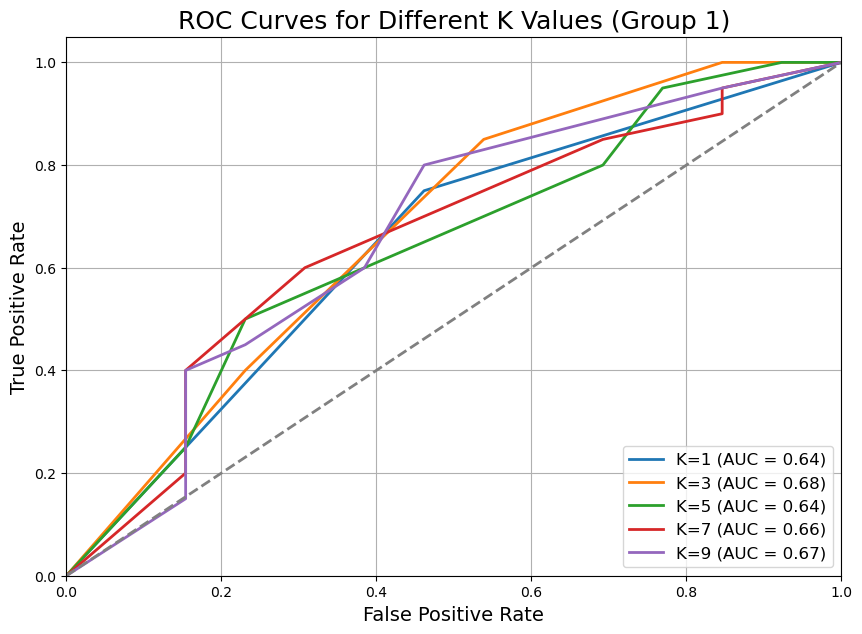

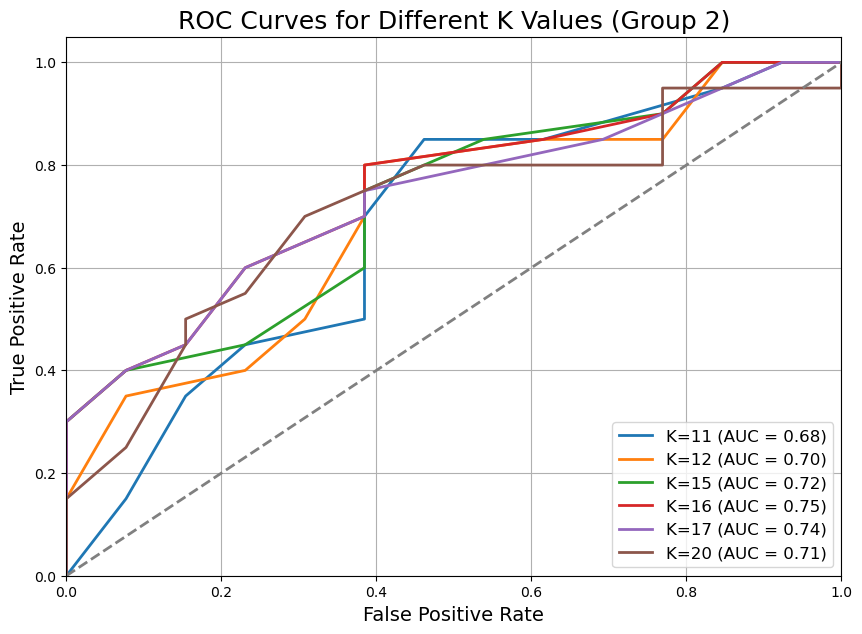

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming 'dados_selecionados' is your DataFrame
# Load your dataset (if not already loaded)
# dados_selecionados = pd.read_csv('your_dataset.csv')

# Separate predictors and target variable
X = dados_selecionados.drop(columns=['Class_LIVES'])
y = dados_selecionados['Class_LIVES']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# List of specific k values to evaluate
k_values = [1, 3, 5, 7, 9, 11, 12, 15, 16, 17, 20]  # Replace with your chosen k values

# Split the k values into two groups
k_values_group1 = k_values[:len(k_values)//2]
k_values_group2 = k_values[len(k_values)//2:]

# Initialize lists to store ROC curves and AUCs
fpr_list = []
tpr_list = []
roc_auc_list = []

# Function to compute ROC curve and AUC for a list of k values
def compute_roc_auc(k_values):
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        
        # Predict probabilities for the positive class
        y_pred_prob = knn.predict_proba(X_test)[:, 1]
        
        # Calculate the ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        
        # Calculate the AUC
        roc_auc = roc_auc_score(y_test, y_pred_prob)
        
        # Store the results
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        roc_auc_list.append(roc_auc)

# Compute ROC and AUC for the first group
compute_roc_auc(k_values_group1)

# Plot the ROC curves for the first group
plt.figure(figsize=(10, 7))

for i, k in enumerate(k_values_group1):
    plt.plot(fpr_list[i], tpr_list[i], lw=2, label=f'K={k} (AUC = {roc_auc_list[i]:.2f})')

# Plot the diagonal line for random guessing
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')

# Plot configuration for the first group
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves for Different K Values (Group 1)', fontsize=18)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

# Clear the lists for the next group
fpr_list.clear()
tpr_list.clear()
roc_auc_list.clear()

# Compute ROC and AUC for the second group
compute_roc_auc(k_values_group2)

# Plot the ROC curves for the second group
plt.figure(figsize=(10, 7))

for i, k in enumerate(k_values_group2):
    plt.plot(fpr_list[i], tpr_list[i], lw=2, label=f'K={k} (AUC = {roc_auc_list[i]:.2f})')

# Plot the diagonal line for random guessing
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')

# Plot configuration for the second group
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves for Different K Values (Group 2)', fontsize=18)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

#### the best k value for the algorithm compared to the other k values is k= 17

In [21]:
import pandas as pd
from sklearn.model_selection import train_tetst_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'dados_selecionados' is your DataFrame
# Load your dataset (if not already loaded)
# dados_selecionados = pd.read_csv('your_dataset.csv')

# Separate predictors and target variable
X = dados_selecionados.drop(columns=['Class_LIVES'])
y = dados_selecionados['Class_LIVES']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Best k value from your previous analysis
best_k = 17  # Replace with your determined best k value

# Retrain the model using the best k value
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn_best.predict(X_test)
y_pred_prob = knn_best.predict_proba(X_test)[:, 1]

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Generate the classification report
report = classification_report(y_test, y_pred)
print("Classification Report")
print(report)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

# Plot the confusion matrix with additional metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
for i in range(len(cm)):
    for j in range(len(cm[i])):
        plt.text(j+0.5, i+0.5, f'{cm[i, j]}\nP: {precision[i]:.2f}\nR: {recall[i]:.2f}\nF1: {f1[i]:.2f}',
                 ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.5))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix with Precision, Recall, and F1-Score (k={best_k})')
plt.show()

# Calculate additional metrics
TN, FP, FN, TP = cm.ravel()
NPV = TN / (TN + FN)
PPV = TP / (TP + FP)
specificity = TN / (TN + FP)
sensitivity = TP / (TP + FN)

print(f'Negative Predictive Value (NPV): {NPV:.2f}')
print(f'Positive Predictive Value (PPV): {PPV:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')

# Calculate the ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (k={best_k})')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Perform cross-validation to ensure generalization
cross_val_scores = cross_val_score(knn_best, X, y, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {cross_val_scores}')
print(f'Mean Cross-Validation Accuracy: {cross_val_scores.mean():.2f}')
print(f'Standard Deviation of Cross-Validation Accuracy: {cross_val_scores.std():.2f}')


ImportError: cannot import name 'train_tetst_split' from 'sklearn.model_selection' (C:\Users\yunni\anaconda3\Lib\site-packages\sklearn\model_selection\__init__.py)